# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

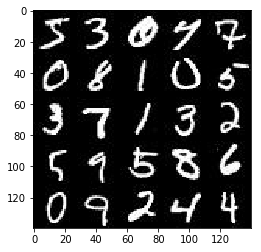

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

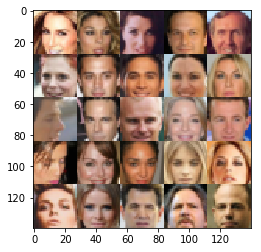

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),'inputs_real')
    inputs_z=tf.placeholder(tf.float32,(None,z_dim),'inputs_zdim')
    learn_rate=tf.placeholder(tf.float32)
    return (inputs_real,inputs_z,learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.15
    with tf.variable_scope("discriminator",reuse=reuse):
        #image is now 14x14x64
        conv1=tf.layers.conv2d(images,64,5,strides=2,padding='SAME')
        relu1=tf.maximum(conv1*alpha,conv1)
        #7x7x128
        conv2=tf.layers.conv2d(relu1,128,5,strides=2,padding='SAME')
        bn2=tf.layers.batch_normalization(conv2,training=True)
        relu2=tf.maximum(bn2*alpha,bn2)
        #4x4x256
        conv3=tf.layers.conv2d(relu2, 256, 5, strides=2,padding='SAME')
        bn3=tf.layers.batch_normalization(conv3,training=True)
        relu3=tf.maximum(bn3*alpha,bn3)
        
        relu3shape=relu3.get_shape().as_list()
        fullyconnected=tf.reshape(relu3,(-1,relu3shape[1]*relu3shape[2]*relu3shape[3]))
        logits=tf.layers.dense(fullyconnected,1)
        out=tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.15
    
    if is_train==True:
        reuse=False
    else:
        reuse=True
    
    with tf.variable_scope("generator",reuse=reuse):
        fully_connected1=tf.layers.dense(z,7*7*512)
        
        # 7x7x512
        reshape1=tf.reshape(fully_connected1,(-1,7,7,512))
        bn1=tf.layers.batch_normalization(reshape1,training=is_train)
        relu1=tf.maximum(alpha*bn1,bn1)
        # 14x14x256
        conv2=tf.layers.conv2d_transpose(relu1,256,5,strides=2,padding='SAME')
        bn2=tf.layers.batch_normalization(conv2,training=is_train)
        relu2=tf.maximum(alpha*bn2,bn2)
        #28x28x128
        conv3=tf.layers.conv2d_transpose(relu2,128,5,strides=2,padding='SAME')
        bn3=tf.layers.batch_normalization(conv3,training=is_train)
        relu3=tf.maximum(alpha*bn3,bn3)
        #output is 28x28xout_channel_dim
        logits=tf.layers.conv2d_transpose(relu3,out_channel_dim,5,strides=1,padding='SAME')
        output=tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    fakeimages=generator(input_z,out_channel_dim=out_channel_dim)
    
    output_real,logits_real=discriminator(input_real)
    output_fake,logits_fake=discriminator(fakeimages,reuse=True)
    
    d_loss_real=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real)*0.9))
    d_loss_fake=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_fake)))
    g_loss=tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))
    d_loss=d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables=tf.trainable_variables()
    d_vars=[var for var in variables if var.name[:3]=='dis']
    g_vars=[var for var in variables if var.name[:3]=='gen']
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt=tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
        return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real,inputs_z,learn_rate=model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss,g_loss=model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt,g_opt=model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        steps=0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run((g_opt,d_opt),feed_dict={inputs_real:batch_images,inputs_z:batch_z})
                sess.run(g_opt,feed_dict={inputs_real:batch_images,inputs_z:batch_z})
                
                disc_loss,gen_loss=sess.run([d_loss,g_loss],feed_dict={inputs_real:batch_images,inputs_z:batch_z})

                
                if steps%10==0:
                    print("Epoch: ",epoch_i,"Batch: ",steps,"Discriminator_Loss: ",disc_loss,"Generator_Loss: ",gen_loss)
                if steps%100==0:
                    show_generator_output(sess, 30, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch:  0 Batch:  10 Discriminator_Loss:  2.08858 Generator_Loss:  0.357684
Epoch:  0 Batch:  20 Discriminator_Loss:  3.70783 Generator_Loss:  0.0418882
Epoch:  0 Batch:  30 Discriminator_Loss:  2.485 Generator_Loss:  0.173054
Epoch:  0 Batch:  40 Discriminator_Loss:  2.3922 Generator_Loss:  0.19019
Epoch:  0 Batch:  50 Discriminator_Loss:  2.30317 Generator_Loss:  0.247637
Epoch:  0 Batch:  60 Discriminator_Loss:  2.1983 Generator_Loss:  0.244139
Epoch:  0 Batch:  70 Discriminator_Loss:  2.66918 Generator_Loss:  0.133679
Epoch:  0 Batch:  80 Discriminator_Loss:  1.90401 Generator_Loss:  0.517805
Epoch:  0 Batch:  90 Discriminator_Loss:  2.22181 Generator_Loss:  0.249
Epoch:  0 Batch:  100 Discriminator_Loss:  1.69469 Generator_Loss:  0.570998


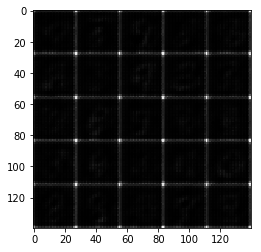

Epoch:  0 Batch:  110 Discriminator_Loss:  2.16437 Generator_Loss:  0.236217
Epoch:  0 Batch:  120 Discriminator_Loss:  1.68118 Generator_Loss:  0.540459
Epoch:  0 Batch:  130 Discriminator_Loss:  1.85701 Generator_Loss:  0.350946
Epoch:  0 Batch:  140 Discriminator_Loss:  2.09434 Generator_Loss:  0.268343
Epoch:  0 Batch:  150 Discriminator_Loss:  1.74523 Generator_Loss:  0.452703
Epoch:  0 Batch:  160 Discriminator_Loss:  1.986 Generator_Loss:  0.27426
Epoch:  0 Batch:  170 Discriminator_Loss:  1.572 Generator_Loss:  0.585888
Epoch:  0 Batch:  180 Discriminator_Loss:  1.7336 Generator_Loss:  0.412122
Epoch:  0 Batch:  190 Discriminator_Loss:  1.4226 Generator_Loss:  1.20717
Epoch:  0 Batch:  200 Discriminator_Loss:  1.86503 Generator_Loss:  0.311487


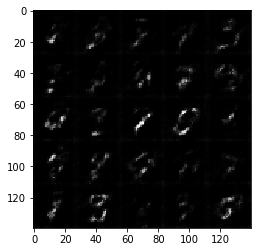

Epoch:  0 Batch:  210 Discriminator_Loss:  1.6219 Generator_Loss:  0.544863
Epoch:  0 Batch:  220 Discriminator_Loss:  1.55877 Generator_Loss:  0.960931
Epoch:  0 Batch:  230 Discriminator_Loss:  1.31776 Generator_Loss:  0.69256
Epoch:  0 Batch:  240 Discriminator_Loss:  2.08618 Generator_Loss:  0.241131
Epoch:  0 Batch:  250 Discriminator_Loss:  1.76642 Generator_Loss:  1.24252
Epoch:  0 Batch:  260 Discriminator_Loss:  1.68606 Generator_Loss:  0.375415
Epoch:  0 Batch:  270 Discriminator_Loss:  1.43051 Generator_Loss:  0.679505
Epoch:  0 Batch:  280 Discriminator_Loss:  1.95515 Generator_Loss:  0.34282
Epoch:  0 Batch:  290 Discriminator_Loss:  1.83941 Generator_Loss:  0.406748
Epoch:  0 Batch:  300 Discriminator_Loss:  2.01042 Generator_Loss:  0.284238


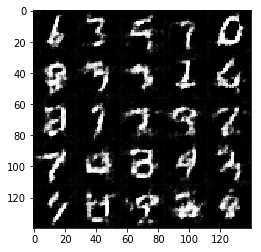

Epoch:  0 Batch:  310 Discriminator_Loss:  2.13769 Generator_Loss:  0.280803
Epoch:  0 Batch:  320 Discriminator_Loss:  1.54505 Generator_Loss:  0.869401
Epoch:  0 Batch:  330 Discriminator_Loss:  1.64698 Generator_Loss:  0.511756
Epoch:  0 Batch:  340 Discriminator_Loss:  1.48313 Generator_Loss:  0.680225
Epoch:  0 Batch:  350 Discriminator_Loss:  1.70384 Generator_Loss:  0.583286
Epoch:  0 Batch:  360 Discriminator_Loss:  1.58114 Generator_Loss:  0.563383
Epoch:  0 Batch:  370 Discriminator_Loss:  1.99371 Generator_Loss:  0.273248
Epoch:  0 Batch:  380 Discriminator_Loss:  1.4864 Generator_Loss:  0.610381
Epoch:  0 Batch:  390 Discriminator_Loss:  1.70021 Generator_Loss:  0.413683
Epoch:  0 Batch:  400 Discriminator_Loss:  1.7676 Generator_Loss:  0.353588


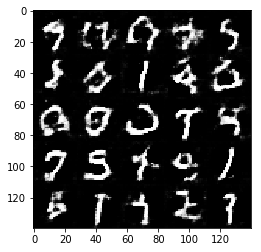

Epoch:  0 Batch:  410 Discriminator_Loss:  1.65158 Generator_Loss:  0.440153
Epoch:  0 Batch:  420 Discriminator_Loss:  1.30078 Generator_Loss:  0.682807
Epoch:  0 Batch:  430 Discriminator_Loss:  1.69649 Generator_Loss:  0.495082
Epoch:  0 Batch:  440 Discriminator_Loss:  2.02828 Generator_Loss:  0.288871
Epoch:  0 Batch:  450 Discriminator_Loss:  1.27019 Generator_Loss:  0.806547
Epoch:  0 Batch:  460 Discriminator_Loss:  1.51247 Generator_Loss:  0.665599
Epoch:  0 Batch:  470 Discriminator_Loss:  1.70524 Generator_Loss:  0.373255
Epoch:  0 Batch:  480 Discriminator_Loss:  1.71919 Generator_Loss:  0.499869
Epoch:  0 Batch:  490 Discriminator_Loss:  1.59401 Generator_Loss:  0.570461
Epoch:  0 Batch:  500 Discriminator_Loss:  1.79112 Generator_Loss:  0.332683


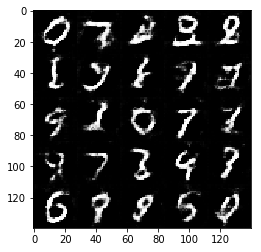

Epoch:  0 Batch:  510 Discriminator_Loss:  1.57905 Generator_Loss:  0.713964
Epoch:  0 Batch:  520 Discriminator_Loss:  1.48171 Generator_Loss:  0.545443
Epoch:  0 Batch:  530 Discriminator_Loss:  1.44232 Generator_Loss:  0.564003
Epoch:  0 Batch:  540 Discriminator_Loss:  1.54829 Generator_Loss:  0.634197
Epoch:  0 Batch:  550 Discriminator_Loss:  1.36084 Generator_Loss:  1.16042
Epoch:  0 Batch:  560 Discriminator_Loss:  1.39802 Generator_Loss:  0.826684
Epoch:  0 Batch:  570 Discriminator_Loss:  1.56001 Generator_Loss:  0.578299
Epoch:  0 Batch:  580 Discriminator_Loss:  1.55036 Generator_Loss:  0.580529
Epoch:  0 Batch:  590 Discriminator_Loss:  1.28317 Generator_Loss:  0.822057
Epoch:  0 Batch:  600 Discriminator_Loss:  1.69149 Generator_Loss:  0.608932


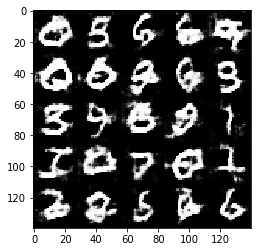

Epoch:  0 Batch:  610 Discriminator_Loss:  1.60882 Generator_Loss:  0.573302
Epoch:  0 Batch:  620 Discriminator_Loss:  1.35527 Generator_Loss:  0.818242
Epoch:  0 Batch:  630 Discriminator_Loss:  1.66757 Generator_Loss:  0.431773
Epoch:  0 Batch:  640 Discriminator_Loss:  1.46671 Generator_Loss:  0.643622
Epoch:  0 Batch:  650 Discriminator_Loss:  1.62145 Generator_Loss:  0.479908
Epoch:  0 Batch:  660 Discriminator_Loss:  1.35625 Generator_Loss:  0.671597
Epoch:  0 Batch:  670 Discriminator_Loss:  1.55919 Generator_Loss:  0.557298
Epoch:  0 Batch:  680 Discriminator_Loss:  1.37069 Generator_Loss:  0.691259
Epoch:  0 Batch:  690 Discriminator_Loss:  1.72604 Generator_Loss:  0.371964
Epoch:  0 Batch:  700 Discriminator_Loss:  1.52513 Generator_Loss:  0.527899


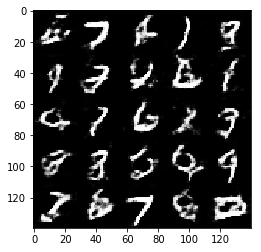

Epoch:  0 Batch:  710 Discriminator_Loss:  2.08439 Generator_Loss:  0.245742
Epoch:  0 Batch:  720 Discriminator_Loss:  1.47489 Generator_Loss:  0.701019
Epoch:  0 Batch:  730 Discriminator_Loss:  1.64 Generator_Loss:  0.476391
Epoch:  0 Batch:  740 Discriminator_Loss:  1.73864 Generator_Loss:  0.395836
Epoch:  0 Batch:  750 Discriminator_Loss:  1.26687 Generator_Loss:  0.754933
Epoch:  0 Batch:  760 Discriminator_Loss:  1.21617 Generator_Loss:  1.15224
Epoch:  0 Batch:  770 Discriminator_Loss:  1.35531 Generator_Loss:  0.646163
Epoch:  0 Batch:  780 Discriminator_Loss:  1.52586 Generator_Loss:  0.507651
Epoch:  0 Batch:  790 Discriminator_Loss:  1.46523 Generator_Loss:  0.723195
Epoch:  0 Batch:  800 Discriminator_Loss:  1.76204 Generator_Loss:  0.329954


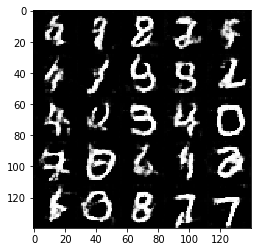

Epoch:  0 Batch:  810 Discriminator_Loss:  1.44289 Generator_Loss:  0.611844
Epoch:  0 Batch:  820 Discriminator_Loss:  1.53982 Generator_Loss:  0.508755
Epoch:  0 Batch:  830 Discriminator_Loss:  2.21924 Generator_Loss:  0.198448
Epoch:  0 Batch:  840 Discriminator_Loss:  1.23026 Generator_Loss:  0.911027
Epoch:  0 Batch:  850 Discriminator_Loss:  1.53994 Generator_Loss:  0.610783
Epoch:  0 Batch:  860 Discriminator_Loss:  1.57673 Generator_Loss:  0.519603
Epoch:  0 Batch:  870 Discriminator_Loss:  1.60556 Generator_Loss:  0.421487
Epoch:  0 Batch:  880 Discriminator_Loss:  1.75721 Generator_Loss:  0.322244
Epoch:  0 Batch:  890 Discriminator_Loss:  1.8075 Generator_Loss:  0.294941
Epoch:  0 Batch:  900 Discriminator_Loss:  1.41688 Generator_Loss:  0.541755


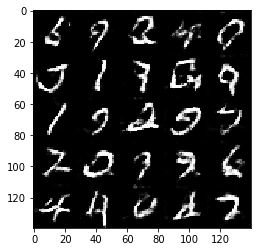

Epoch:  0 Batch:  910 Discriminator_Loss:  1.26958 Generator_Loss:  0.940061
Epoch:  0 Batch:  920 Discriminator_Loss:  1.4393 Generator_Loss:  0.589063
Epoch:  0 Batch:  930 Discriminator_Loss:  1.58177 Generator_Loss:  0.781373
Epoch:  0 Batch:  940 Discriminator_Loss:  1.49575 Generator_Loss:  0.529866
Epoch:  0 Batch:  950 Discriminator_Loss:  1.37322 Generator_Loss:  0.60881
Epoch:  0 Batch:  960 Discriminator_Loss:  1.32919 Generator_Loss:  0.81619
Epoch:  0 Batch:  970 Discriminator_Loss:  1.82199 Generator_Loss:  0.355827
Epoch:  0 Batch:  980 Discriminator_Loss:  1.429 Generator_Loss:  1.53703
Epoch:  0 Batch:  990 Discriminator_Loss:  1.45551 Generator_Loss:  0.526483
Epoch:  0 Batch:  1000 Discriminator_Loss:  2.35191 Generator_Loss:  0.170077


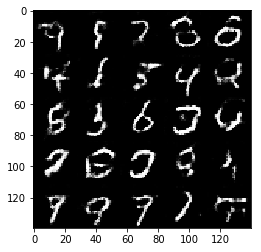

Epoch:  0 Batch:  1010 Discriminator_Loss:  1.59214 Generator_Loss:  0.421339
Epoch:  0 Batch:  1020 Discriminator_Loss:  1.46824 Generator_Loss:  0.739042
Epoch:  0 Batch:  1030 Discriminator_Loss:  1.38898 Generator_Loss:  0.57854
Epoch:  0 Batch:  1040 Discriminator_Loss:  1.46371 Generator_Loss:  0.532665
Epoch:  0 Batch:  1050 Discriminator_Loss:  1.34552 Generator_Loss:  0.673264
Epoch:  0 Batch:  1060 Discriminator_Loss:  1.39294 Generator_Loss:  0.625493
Epoch:  0 Batch:  1070 Discriminator_Loss:  1.40414 Generator_Loss:  0.551736
Epoch:  0 Batch:  1080 Discriminator_Loss:  1.7324 Generator_Loss:  0.362253
Epoch:  0 Batch:  1090 Discriminator_Loss:  1.28638 Generator_Loss:  0.694366
Epoch:  0 Batch:  1100 Discriminator_Loss:  1.66308 Generator_Loss:  0.383408


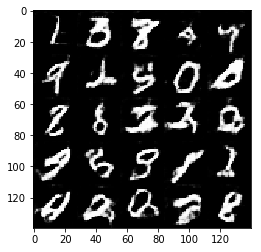

Epoch:  0 Batch:  1110 Discriminator_Loss:  1.55059 Generator_Loss:  0.473141
Epoch:  0 Batch:  1120 Discriminator_Loss:  1.39635 Generator_Loss:  0.690949
Epoch:  0 Batch:  1130 Discriminator_Loss:  1.75556 Generator_Loss:  0.332449
Epoch:  0 Batch:  1140 Discriminator_Loss:  1.47702 Generator_Loss:  0.693661
Epoch:  0 Batch:  1150 Discriminator_Loss:  1.37662 Generator_Loss:  1.06955
Epoch:  0 Batch:  1160 Discriminator_Loss:  1.42806 Generator_Loss:  0.487424
Epoch:  0 Batch:  1170 Discriminator_Loss:  1.47714 Generator_Loss:  0.505914
Epoch:  0 Batch:  1180 Discriminator_Loss:  1.45461 Generator_Loss:  0.515355
Epoch:  0 Batch:  1190 Discriminator_Loss:  1.597 Generator_Loss:  0.39845
Epoch:  0 Batch:  1200 Discriminator_Loss:  1.31507 Generator_Loss:  1.01117


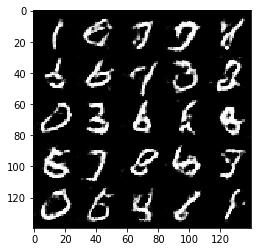

Epoch:  0 Batch:  1210 Discriminator_Loss:  1.26286 Generator_Loss:  0.758051
Epoch:  0 Batch:  1220 Discriminator_Loss:  1.41998 Generator_Loss:  0.52033
Epoch:  0 Batch:  1230 Discriminator_Loss:  1.56758 Generator_Loss:  0.458838
Epoch:  0 Batch:  1240 Discriminator_Loss:  1.28138 Generator_Loss:  0.738883
Epoch:  0 Batch:  1250 Discriminator_Loss:  1.31534 Generator_Loss:  0.735737
Epoch:  0 Batch:  1260 Discriminator_Loss:  1.45412 Generator_Loss:  0.541716
Epoch:  0 Batch:  1270 Discriminator_Loss:  1.56433 Generator_Loss:  0.457184
Epoch:  0 Batch:  1280 Discriminator_Loss:  1.4395 Generator_Loss:  0.556616
Epoch:  0 Batch:  1290 Discriminator_Loss:  1.76157 Generator_Loss:  0.345812
Epoch:  0 Batch:  1300 Discriminator_Loss:  2.95556 Generator_Loss:  0.105568


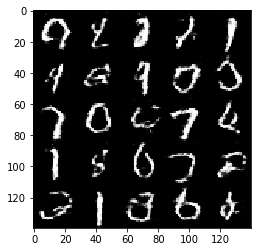

Epoch:  0 Batch:  1310 Discriminator_Loss:  1.23915 Generator_Loss:  0.976712
Epoch:  0 Batch:  1320 Discriminator_Loss:  1.33801 Generator_Loss:  0.63876
Epoch:  0 Batch:  1330 Discriminator_Loss:  1.32353 Generator_Loss:  0.696444
Epoch:  0 Batch:  1340 Discriminator_Loss:  1.32918 Generator_Loss:  0.604388
Epoch:  0 Batch:  1350 Discriminator_Loss:  1.61227 Generator_Loss:  0.428307
Epoch:  0 Batch:  1360 Discriminator_Loss:  1.92253 Generator_Loss:  0.297559
Epoch:  0 Batch:  1370 Discriminator_Loss:  1.32399 Generator_Loss:  0.675338
Epoch:  0 Batch:  1380 Discriminator_Loss:  1.57314 Generator_Loss:  0.455459
Epoch:  0 Batch:  1390 Discriminator_Loss:  1.22473 Generator_Loss:  0.87596
Epoch:  0 Batch:  1400 Discriminator_Loss:  1.27555 Generator_Loss:  0.650745


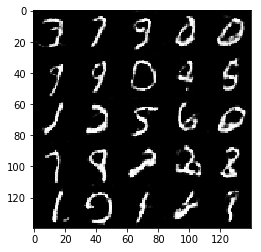

Epoch:  0 Batch:  1410 Discriminator_Loss:  1.2766 Generator_Loss:  1.19599
Epoch:  0 Batch:  1420 Discriminator_Loss:  1.46767 Generator_Loss:  0.578597
Epoch:  0 Batch:  1430 Discriminator_Loss:  1.59573 Generator_Loss:  0.450518
Epoch:  0 Batch:  1440 Discriminator_Loss:  1.57631 Generator_Loss:  0.572071
Epoch:  0 Batch:  1450 Discriminator_Loss:  1.48739 Generator_Loss:  0.543442
Epoch:  0 Batch:  1460 Discriminator_Loss:  1.29207 Generator_Loss:  0.690574
Epoch:  0 Batch:  1470 Discriminator_Loss:  1.57152 Generator_Loss:  0.422696
Epoch:  0 Batch:  1480 Discriminator_Loss:  1.31833 Generator_Loss:  0.647687
Epoch:  0 Batch:  1490 Discriminator_Loss:  1.60589 Generator_Loss:  0.401784
Epoch:  0 Batch:  1500 Discriminator_Loss:  1.443 Generator_Loss:  0.89129


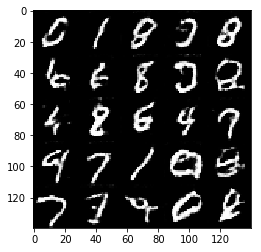

Epoch:  0 Batch:  1510 Discriminator_Loss:  1.70099 Generator_Loss:  0.423643
Epoch:  0 Batch:  1520 Discriminator_Loss:  1.19517 Generator_Loss:  0.83729
Epoch:  0 Batch:  1530 Discriminator_Loss:  1.43468 Generator_Loss:  0.495866
Epoch:  0 Batch:  1540 Discriminator_Loss:  1.15149 Generator_Loss:  0.779316
Epoch:  0 Batch:  1550 Discriminator_Loss:  1.10761 Generator_Loss:  0.883808
Epoch:  0 Batch:  1560 Discriminator_Loss:  1.33654 Generator_Loss:  0.97173
Epoch:  0 Batch:  1570 Discriminator_Loss:  1.365 Generator_Loss:  0.571981
Epoch:  0 Batch:  1580 Discriminator_Loss:  1.35352 Generator_Loss:  0.908027
Epoch:  0 Batch:  1590 Discriminator_Loss:  1.15081 Generator_Loss:  1.10003
Epoch:  0 Batch:  1600 Discriminator_Loss:  1.45493 Generator_Loss:  0.48252


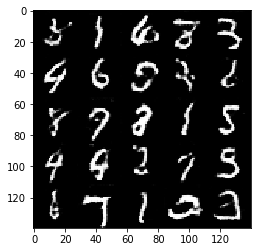

Epoch:  0 Batch:  1610 Discriminator_Loss:  1.39989 Generator_Loss:  0.545707
Epoch:  0 Batch:  1620 Discriminator_Loss:  1.17487 Generator_Loss:  1.01183
Epoch:  0 Batch:  1630 Discriminator_Loss:  1.23525 Generator_Loss:  0.981047
Epoch:  0 Batch:  1640 Discriminator_Loss:  1.38652 Generator_Loss:  0.5476
Epoch:  0 Batch:  1650 Discriminator_Loss:  1.07141 Generator_Loss:  0.821497
Epoch:  0 Batch:  1660 Discriminator_Loss:  1.45886 Generator_Loss:  0.46472
Epoch:  0 Batch:  1670 Discriminator_Loss:  1.38567 Generator_Loss:  0.539968
Epoch:  0 Batch:  1680 Discriminator_Loss:  1.21311 Generator_Loss:  0.755143
Epoch:  0 Batch:  1690 Discriminator_Loss:  1.24325 Generator_Loss:  0.934521
Epoch:  0 Batch:  1700 Discriminator_Loss:  1.32596 Generator_Loss:  0.676663


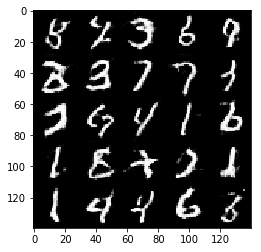

Epoch:  0 Batch:  1710 Discriminator_Loss:  1.19005 Generator_Loss:  0.718656
Epoch:  0 Batch:  1720 Discriminator_Loss:  0.70791 Generator_Loss:  1.38649
Epoch:  0 Batch:  1730 Discriminator_Loss:  1.26618 Generator_Loss:  0.833224
Epoch:  0 Batch:  1740 Discriminator_Loss:  1.47441 Generator_Loss:  0.68599
Epoch:  0 Batch:  1750 Discriminator_Loss:  1.31853 Generator_Loss:  0.715189
Epoch:  0 Batch:  1760 Discriminator_Loss:  1.27172 Generator_Loss:  0.603055
Epoch:  0 Batch:  1770 Discriminator_Loss:  1.45432 Generator_Loss:  0.554098
Epoch:  0 Batch:  1780 Discriminator_Loss:  1.29238 Generator_Loss:  0.854466
Epoch:  0 Batch:  1790 Discriminator_Loss:  1.10275 Generator_Loss:  1.06509
Epoch:  0 Batch:  1800 Discriminator_Loss:  1.0315 Generator_Loss:  1.08862


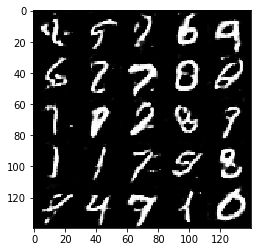

Epoch:  0 Batch:  1810 Discriminator_Loss:  1.40858 Generator_Loss:  0.491646
Epoch:  0 Batch:  1820 Discriminator_Loss:  1.32412 Generator_Loss:  0.591926
Epoch:  0 Batch:  1830 Discriminator_Loss:  1.35763 Generator_Loss:  0.752766
Epoch:  0 Batch:  1840 Discriminator_Loss:  1.22667 Generator_Loss:  0.7208
Epoch:  0 Batch:  1850 Discriminator_Loss:  1.39327 Generator_Loss:  0.622079
Epoch:  0 Batch:  1860 Discriminator_Loss:  1.51967 Generator_Loss:  0.457491
Epoch:  0 Batch:  1870 Discriminator_Loss:  1.32717 Generator_Loss:  0.513985
Epoch:  1 Batch:  1880 Discriminator_Loss:  1.23489 Generator_Loss:  0.836951
Epoch:  1 Batch:  1890 Discriminator_Loss:  1.64127 Generator_Loss:  0.445599
Epoch:  1 Batch:  1900 Discriminator_Loss:  1.16528 Generator_Loss:  1.17437


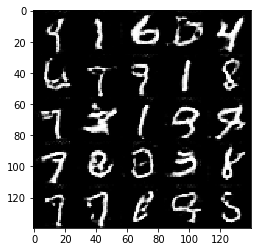

Epoch:  1 Batch:  1910 Discriminator_Loss:  1.41556 Generator_Loss:  0.557945
Epoch:  1 Batch:  1920 Discriminator_Loss:  1.3803 Generator_Loss:  0.600536
Epoch:  1 Batch:  1930 Discriminator_Loss:  1.41754 Generator_Loss:  1.01845
Epoch:  1 Batch:  1940 Discriminator_Loss:  1.33227 Generator_Loss:  0.676265
Epoch:  1 Batch:  1950 Discriminator_Loss:  1.12802 Generator_Loss:  0.760082
Epoch:  1 Batch:  1960 Discriminator_Loss:  1.35596 Generator_Loss:  0.576045
Epoch:  1 Batch:  1970 Discriminator_Loss:  1.39614 Generator_Loss:  0.524748
Epoch:  1 Batch:  1980 Discriminator_Loss:  2.02653 Generator_Loss:  0.251453
Epoch:  1 Batch:  1990 Discriminator_Loss:  1.08598 Generator_Loss:  0.982594
Epoch:  1 Batch:  2000 Discriminator_Loss:  1.23275 Generator_Loss:  0.835188


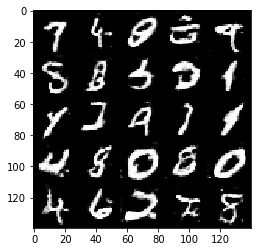

Epoch:  1 Batch:  2010 Discriminator_Loss:  1.2519 Generator_Loss:  1.4497
Epoch:  1 Batch:  2020 Discriminator_Loss:  1.133 Generator_Loss:  0.850336
Epoch:  1 Batch:  2030 Discriminator_Loss:  1.23525 Generator_Loss:  0.625548
Epoch:  1 Batch:  2040 Discriminator_Loss:  1.07756 Generator_Loss:  0.82254
Epoch:  1 Batch:  2050 Discriminator_Loss:  1.13045 Generator_Loss:  1.01336
Epoch:  1 Batch:  2060 Discriminator_Loss:  1.00976 Generator_Loss:  1.04291
Epoch:  1 Batch:  2070 Discriminator_Loss:  1.2778 Generator_Loss:  0.604114
Epoch:  1 Batch:  2080 Discriminator_Loss:  1.92992 Generator_Loss:  0.273548
Epoch:  1 Batch:  2090 Discriminator_Loss:  1.45538 Generator_Loss:  0.509567
Epoch:  1 Batch:  2100 Discriminator_Loss:  1.04318 Generator_Loss:  1.0674


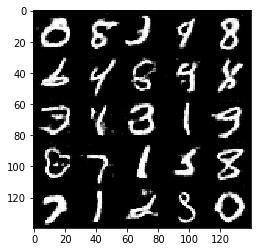

Epoch:  1 Batch:  2110 Discriminator_Loss:  1.42738 Generator_Loss:  0.50373
Epoch:  1 Batch:  2120 Discriminator_Loss:  1.13177 Generator_Loss:  0.861302
Epoch:  1 Batch:  2130 Discriminator_Loss:  1.56871 Generator_Loss:  0.430285
Epoch:  1 Batch:  2140 Discriminator_Loss:  1.20146 Generator_Loss:  1.31005
Epoch:  1 Batch:  2150 Discriminator_Loss:  1.65628 Generator_Loss:  0.440709
Epoch:  1 Batch:  2160 Discriminator_Loss:  1.30037 Generator_Loss:  0.574178
Epoch:  1 Batch:  2170 Discriminator_Loss:  1.68529 Generator_Loss:  0.358986
Epoch:  1 Batch:  2180 Discriminator_Loss:  1.05669 Generator_Loss:  1.02433
Epoch:  1 Batch:  2190 Discriminator_Loss:  1.08933 Generator_Loss:  1.03818
Epoch:  1 Batch:  2200 Discriminator_Loss:  1.21589 Generator_Loss:  0.660064


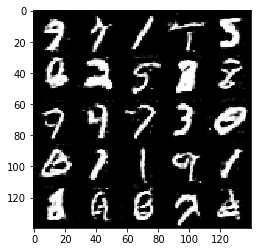

Epoch:  1 Batch:  2210 Discriminator_Loss:  1.3487 Generator_Loss:  1.689
Epoch:  1 Batch:  2220 Discriminator_Loss:  1.27708 Generator_Loss:  0.62779
Epoch:  1 Batch:  2230 Discriminator_Loss:  1.36482 Generator_Loss:  0.555986
Epoch:  1 Batch:  2240 Discriminator_Loss:  0.886976 Generator_Loss:  1.35534
Epoch:  1 Batch:  2250 Discriminator_Loss:  1.09531 Generator_Loss:  0.908917
Epoch:  1 Batch:  2260 Discriminator_Loss:  1.07985 Generator_Loss:  1.32852
Epoch:  1 Batch:  2270 Discriminator_Loss:  1.6356 Generator_Loss:  0.439516
Epoch:  1 Batch:  2280 Discriminator_Loss:  2.00237 Generator_Loss:  0.267133
Epoch:  1 Batch:  2290 Discriminator_Loss:  1.40804 Generator_Loss:  0.520631
Epoch:  1 Batch:  2300 Discriminator_Loss:  1.10746 Generator_Loss:  0.84555


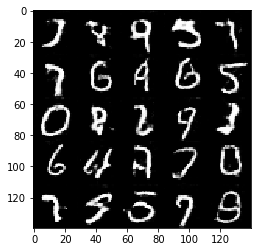

Epoch:  1 Batch:  2310 Discriminator_Loss:  1.05068 Generator_Loss:  1.04072
Epoch:  1 Batch:  2320 Discriminator_Loss:  1.48471 Generator_Loss:  0.458515
Epoch:  1 Batch:  2330 Discriminator_Loss:  1.41267 Generator_Loss:  0.562855
Epoch:  1 Batch:  2340 Discriminator_Loss:  1.42743 Generator_Loss:  0.537206
Epoch:  1 Batch:  2350 Discriminator_Loss:  1.00753 Generator_Loss:  0.855208
Epoch:  1 Batch:  2360 Discriminator_Loss:  1.53375 Generator_Loss:  0.446138
Epoch:  1 Batch:  2370 Discriminator_Loss:  1.19878 Generator_Loss:  0.699736
Epoch:  1 Batch:  2380 Discriminator_Loss:  1.24353 Generator_Loss:  0.731372
Epoch:  1 Batch:  2390 Discriminator_Loss:  1.10308 Generator_Loss:  1.64808
Epoch:  1 Batch:  2400 Discriminator_Loss:  1.22045 Generator_Loss:  0.778678


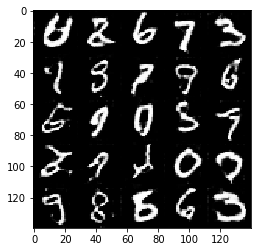

Epoch:  1 Batch:  2410 Discriminator_Loss:  1.13644 Generator_Loss:  0.778249
Epoch:  1 Batch:  2420 Discriminator_Loss:  1.10545 Generator_Loss:  1.31949
Epoch:  1 Batch:  2430 Discriminator_Loss:  1.32664 Generator_Loss:  0.567318
Epoch:  1 Batch:  2440 Discriminator_Loss:  1.60369 Generator_Loss:  0.483017
Epoch:  1 Batch:  2450 Discriminator_Loss:  1.15218 Generator_Loss:  0.844572
Epoch:  1 Batch:  2460 Discriminator_Loss:  1.09979 Generator_Loss:  0.959548
Epoch:  1 Batch:  2470 Discriminator_Loss:  1.67211 Generator_Loss:  0.425646
Epoch:  1 Batch:  2480 Discriminator_Loss:  1.18313 Generator_Loss:  0.705565
Epoch:  1 Batch:  2490 Discriminator_Loss:  1.29649 Generator_Loss:  0.595491
Epoch:  1 Batch:  2500 Discriminator_Loss:  1.40696 Generator_Loss:  0.680867


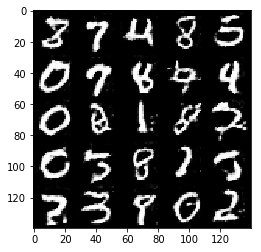

Epoch:  1 Batch:  2510 Discriminator_Loss:  1.81344 Generator_Loss:  0.300603
Epoch:  1 Batch:  2520 Discriminator_Loss:  1.36107 Generator_Loss:  0.729985
Epoch:  1 Batch:  2530 Discriminator_Loss:  1.37221 Generator_Loss:  0.552344
Epoch:  1 Batch:  2540 Discriminator_Loss:  1.27794 Generator_Loss:  0.845489
Epoch:  1 Batch:  2550 Discriminator_Loss:  1.36983 Generator_Loss:  0.527344
Epoch:  1 Batch:  2560 Discriminator_Loss:  1.28304 Generator_Loss:  0.706561
Epoch:  1 Batch:  2570 Discriminator_Loss:  1.73266 Generator_Loss:  0.345107
Epoch:  1 Batch:  2580 Discriminator_Loss:  1.39712 Generator_Loss:  0.572776
Epoch:  1 Batch:  2590 Discriminator_Loss:  1.27111 Generator_Loss:  0.71656
Epoch:  1 Batch:  2600 Discriminator_Loss:  1.10598 Generator_Loss:  0.817647


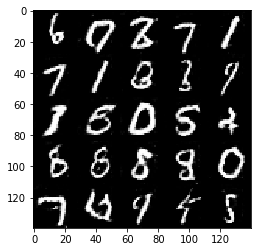

Epoch:  1 Batch:  2610 Discriminator_Loss:  1.50666 Generator_Loss:  0.499969
Epoch:  1 Batch:  2620 Discriminator_Loss:  1.19421 Generator_Loss:  0.709149
Epoch:  1 Batch:  2630 Discriminator_Loss:  0.862991 Generator_Loss:  1.1944
Epoch:  1 Batch:  2640 Discriminator_Loss:  1.63837 Generator_Loss:  0.46864
Epoch:  1 Batch:  2650 Discriminator_Loss:  1.62608 Generator_Loss:  0.535933
Epoch:  1 Batch:  2660 Discriminator_Loss:  1.08479 Generator_Loss:  1.00409
Epoch:  1 Batch:  2670 Discriminator_Loss:  1.35505 Generator_Loss:  0.601569
Epoch:  1 Batch:  2680 Discriminator_Loss:  1.1938 Generator_Loss:  0.741357
Epoch:  1 Batch:  2690 Discriminator_Loss:  1.21091 Generator_Loss:  0.704895
Epoch:  1 Batch:  2700 Discriminator_Loss:  1.58142 Generator_Loss:  0.435899


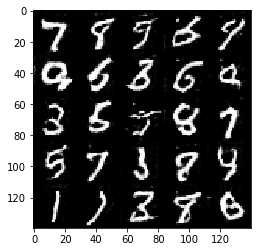

Epoch:  1 Batch:  2710 Discriminator_Loss:  1.01382 Generator_Loss:  0.886001
Epoch:  1 Batch:  2720 Discriminator_Loss:  1.40173 Generator_Loss:  0.542513
Epoch:  1 Batch:  2730 Discriminator_Loss:  1.61099 Generator_Loss:  0.447076
Epoch:  1 Batch:  2740 Discriminator_Loss:  1.05098 Generator_Loss:  0.953507
Epoch:  1 Batch:  2750 Discriminator_Loss:  1.2701 Generator_Loss:  0.662521
Epoch:  1 Batch:  2760 Discriminator_Loss:  1.31103 Generator_Loss:  0.604281
Epoch:  1 Batch:  2770 Discriminator_Loss:  1.38493 Generator_Loss:  0.685443
Epoch:  1 Batch:  2780 Discriminator_Loss:  0.854405 Generator_Loss:  1.28969
Epoch:  1 Batch:  2790 Discriminator_Loss:  1.37202 Generator_Loss:  0.573078
Epoch:  1 Batch:  2800 Discriminator_Loss:  1.52448 Generator_Loss:  0.459288


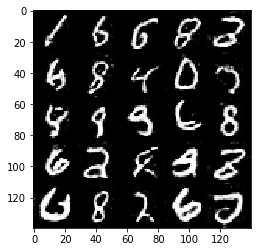

Epoch:  1 Batch:  2810 Discriminator_Loss:  1.75558 Generator_Loss:  0.386708
Epoch:  1 Batch:  2820 Discriminator_Loss:  1.17434 Generator_Loss:  0.758176
Epoch:  1 Batch:  2830 Discriminator_Loss:  1.64921 Generator_Loss:  0.436381
Epoch:  1 Batch:  2840 Discriminator_Loss:  1.40931 Generator_Loss:  0.606452
Epoch:  1 Batch:  2850 Discriminator_Loss:  1.52179 Generator_Loss:  0.45847
Epoch:  1 Batch:  2860 Discriminator_Loss:  1.47199 Generator_Loss:  0.471045
Epoch:  1 Batch:  2870 Discriminator_Loss:  1.51598 Generator_Loss:  0.471012
Epoch:  1 Batch:  2880 Discriminator_Loss:  1.26139 Generator_Loss:  0.718129
Epoch:  1 Batch:  2890 Discriminator_Loss:  1.57687 Generator_Loss:  0.430203
Epoch:  1 Batch:  2900 Discriminator_Loss:  1.72574 Generator_Loss:  0.379064


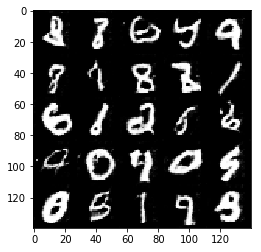

Epoch:  1 Batch:  2910 Discriminator_Loss:  1.58008 Generator_Loss:  0.474807
Epoch:  1 Batch:  2920 Discriminator_Loss:  1.32622 Generator_Loss:  0.598495
Epoch:  1 Batch:  2930 Discriminator_Loss:  1.0268 Generator_Loss:  0.930979
Epoch:  1 Batch:  2940 Discriminator_Loss:  1.39954 Generator_Loss:  0.48672
Epoch:  1 Batch:  2950 Discriminator_Loss:  1.10758 Generator_Loss:  0.746678
Epoch:  1 Batch:  2960 Discriminator_Loss:  0.986746 Generator_Loss:  0.981269
Epoch:  1 Batch:  2970 Discriminator_Loss:  1.11875 Generator_Loss:  0.788075
Epoch:  1 Batch:  2980 Discriminator_Loss:  1.4764 Generator_Loss:  0.527855
Epoch:  1 Batch:  2990 Discriminator_Loss:  1.23567 Generator_Loss:  0.707423
Epoch:  1 Batch:  3000 Discriminator_Loss:  1.10651 Generator_Loss:  0.833396


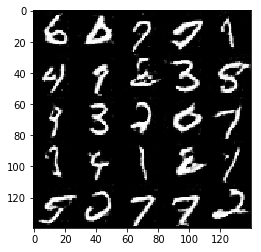

Epoch:  1 Batch:  3010 Discriminator_Loss:  1.23248 Generator_Loss:  0.666551
Epoch:  1 Batch:  3020 Discriminator_Loss:  1.18144 Generator_Loss:  0.904433
Epoch:  1 Batch:  3030 Discriminator_Loss:  1.10422 Generator_Loss:  0.7656
Epoch:  1 Batch:  3040 Discriminator_Loss:  1.31149 Generator_Loss:  0.575421
Epoch:  1 Batch:  3050 Discriminator_Loss:  1.16517 Generator_Loss:  0.850266
Epoch:  1 Batch:  3060 Discriminator_Loss:  1.36149 Generator_Loss:  0.603825
Epoch:  1 Batch:  3070 Discriminator_Loss:  1.02361 Generator_Loss:  0.88686
Epoch:  1 Batch:  3080 Discriminator_Loss:  1.19569 Generator_Loss:  0.661619
Epoch:  1 Batch:  3090 Discriminator_Loss:  1.47533 Generator_Loss:  0.523207
Epoch:  1 Batch:  3100 Discriminator_Loss:  1.11643 Generator_Loss:  0.689007


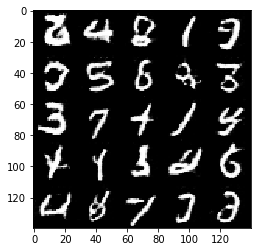

Epoch:  1 Batch:  3110 Discriminator_Loss:  0.996981 Generator_Loss:  0.879039
Epoch:  1 Batch:  3120 Discriminator_Loss:  1.23 Generator_Loss:  0.836582
Epoch:  1 Batch:  3130 Discriminator_Loss:  1.14956 Generator_Loss:  0.778108
Epoch:  1 Batch:  3140 Discriminator_Loss:  1.46399 Generator_Loss:  0.519222
Epoch:  1 Batch:  3150 Discriminator_Loss:  1.86008 Generator_Loss:  0.359321
Epoch:  1 Batch:  3160 Discriminator_Loss:  1.26355 Generator_Loss:  0.667661
Epoch:  1 Batch:  3170 Discriminator_Loss:  1.39569 Generator_Loss:  0.603806
Epoch:  1 Batch:  3180 Discriminator_Loss:  1.30579 Generator_Loss:  0.845497
Epoch:  1 Batch:  3190 Discriminator_Loss:  1.37495 Generator_Loss:  0.657318
Epoch:  1 Batch:  3200 Discriminator_Loss:  1.45014 Generator_Loss:  1.38648


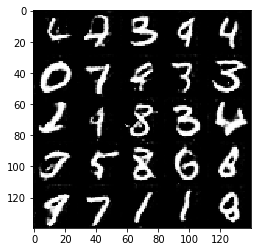

Epoch:  1 Batch:  3210 Discriminator_Loss:  1.61754 Generator_Loss:  0.388484
Epoch:  1 Batch:  3220 Discriminator_Loss:  1.21839 Generator_Loss:  0.800844
Epoch:  1 Batch:  3230 Discriminator_Loss:  2.05152 Generator_Loss:  0.269776
Epoch:  1 Batch:  3240 Discriminator_Loss:  1.53644 Generator_Loss:  0.477384
Epoch:  1 Batch:  3250 Discriminator_Loss:  1.09634 Generator_Loss:  0.872
Epoch:  1 Batch:  3260 Discriminator_Loss:  1.13008 Generator_Loss:  0.782213
Epoch:  1 Batch:  3270 Discriminator_Loss:  1.17917 Generator_Loss:  0.705685
Epoch:  1 Batch:  3280 Discriminator_Loss:  1.72181 Generator_Loss:  0.566202
Epoch:  1 Batch:  3290 Discriminator_Loss:  1.45868 Generator_Loss:  0.486941
Epoch:  1 Batch:  3300 Discriminator_Loss:  1.00315 Generator_Loss:  1.02624


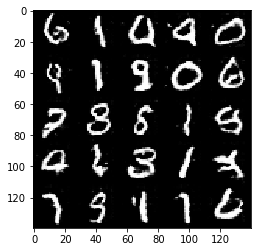

Epoch:  1 Batch:  3310 Discriminator_Loss:  1.4312 Generator_Loss:  0.498316
Epoch:  1 Batch:  3320 Discriminator_Loss:  0.964774 Generator_Loss:  0.91296
Epoch:  1 Batch:  3330 Discriminator_Loss:  1.2453 Generator_Loss:  1.0068
Epoch:  1 Batch:  3340 Discriminator_Loss:  0.923351 Generator_Loss:  1.06954
Epoch:  1 Batch:  3350 Discriminator_Loss:  1.10058 Generator_Loss:  0.933538
Epoch:  1 Batch:  3360 Discriminator_Loss:  0.89266 Generator_Loss:  1.07584
Epoch:  1 Batch:  3370 Discriminator_Loss:  2.02554 Generator_Loss:  0.252304
Epoch:  1 Batch:  3380 Discriminator_Loss:  1.30907 Generator_Loss:  0.779531
Epoch:  1 Batch:  3390 Discriminator_Loss:  0.963778 Generator_Loss:  1.05849
Epoch:  1 Batch:  3400 Discriminator_Loss:  1.3993 Generator_Loss:  0.537805


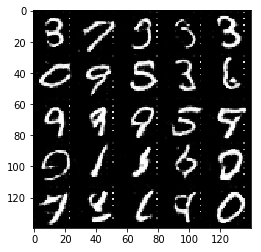

Epoch:  1 Batch:  3410 Discriminator_Loss:  1.21643 Generator_Loss:  0.703054
Epoch:  1 Batch:  3420 Discriminator_Loss:  1.12169 Generator_Loss:  0.709662
Epoch:  1 Batch:  3430 Discriminator_Loss:  1.12667 Generator_Loss:  0.742441
Epoch:  1 Batch:  3440 Discriminator_Loss:  1.12592 Generator_Loss:  0.95033
Epoch:  1 Batch:  3450 Discriminator_Loss:  1.75318 Generator_Loss:  0.362345
Epoch:  1 Batch:  3460 Discriminator_Loss:  1.26819 Generator_Loss:  0.671144
Epoch:  1 Batch:  3470 Discriminator_Loss:  1.28029 Generator_Loss:  0.636105
Epoch:  1 Batch:  3480 Discriminator_Loss:  1.11742 Generator_Loss:  0.718937
Epoch:  1 Batch:  3490 Discriminator_Loss:  1.20837 Generator_Loss:  1.14235
Epoch:  1 Batch:  3500 Discriminator_Loss:  1.1265 Generator_Loss:  0.849563


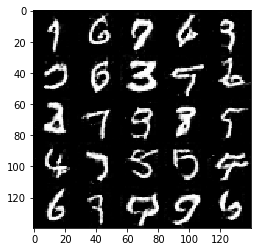

Epoch:  1 Batch:  3510 Discriminator_Loss:  1.57774 Generator_Loss:  0.457391
Epoch:  1 Batch:  3520 Discriminator_Loss:  1.34546 Generator_Loss:  0.560628
Epoch:  1 Batch:  3530 Discriminator_Loss:  1.73064 Generator_Loss:  0.356341
Epoch:  1 Batch:  3540 Discriminator_Loss:  1.29476 Generator_Loss:  0.566184
Epoch:  1 Batch:  3550 Discriminator_Loss:  1.41046 Generator_Loss:  0.622004
Epoch:  1 Batch:  3560 Discriminator_Loss:  1.07998 Generator_Loss:  1.11636
Epoch:  1 Batch:  3570 Discriminator_Loss:  1.42974 Generator_Loss:  0.651324
Epoch:  1 Batch:  3580 Discriminator_Loss:  1.07709 Generator_Loss:  0.796817
Epoch:  1 Batch:  3590 Discriminator_Loss:  2.69865 Generator_Loss:  0.175176
Epoch:  1 Batch:  3600 Discriminator_Loss:  1.14682 Generator_Loss:  0.713854


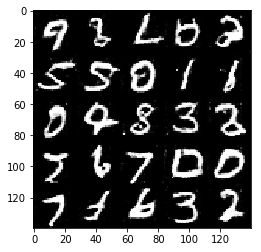

Epoch:  1 Batch:  3610 Discriminator_Loss:  0.999655 Generator_Loss:  0.938685
Epoch:  1 Batch:  3620 Discriminator_Loss:  1.71465 Generator_Loss:  0.367026
Epoch:  1 Batch:  3630 Discriminator_Loss:  1.33233 Generator_Loss:  0.581569
Epoch:  1 Batch:  3640 Discriminator_Loss:  1.5903 Generator_Loss:  0.399679
Epoch:  1 Batch:  3650 Discriminator_Loss:  0.899073 Generator_Loss:  0.962787
Epoch:  1 Batch:  3660 Discriminator_Loss:  1.47082 Generator_Loss:  0.425615
Epoch:  1 Batch:  3670 Discriminator_Loss:  1.33133 Generator_Loss:  0.600195
Epoch:  1 Batch:  3680 Discriminator_Loss:  1.68323 Generator_Loss:  0.355624
Epoch:  1 Batch:  3690 Discriminator_Loss:  1.81524 Generator_Loss:  0.320912
Epoch:  1 Batch:  3700 Discriminator_Loss:  1.2158 Generator_Loss:  1.04127


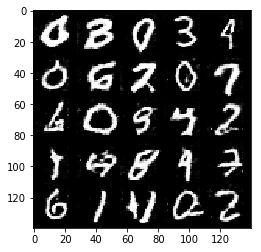

Epoch:  1 Batch:  3710 Discriminator_Loss:  1.23011 Generator_Loss:  0.625631
Epoch:  1 Batch:  3720 Discriminator_Loss:  1.26614 Generator_Loss:  0.612786
Epoch:  1 Batch:  3730 Discriminator_Loss:  1.37769 Generator_Loss:  0.527586
Epoch:  1 Batch:  3740 Discriminator_Loss:  1.87217 Generator_Loss:  0.294265
Epoch:  1 Batch:  3750 Discriminator_Loss:  1.20458 Generator_Loss:  0.712643


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:  0 Batch:  10 Discriminator_Loss:  2.89513 Generator_Loss:  0.155819
Epoch:  0 Batch:  20 Discriminator_Loss:  3.34452 Generator_Loss:  0.0605209
Epoch:  0 Batch:  30 Discriminator_Loss:  1.68316 Generator_Loss:  0.881606
Epoch:  0 Batch:  40 Discriminator_Loss:  1.5701 Generator_Loss:  1.66861
Epoch:  0 Batch:  50 Discriminator_Loss:  2.87913 Generator_Loss:  0.138217
Epoch:  0 Batch:  60 Discriminator_Loss:  1.84612 Generator_Loss:  1.217
Epoch:  0 Batch:  70 Discriminator_Loss:  1.8914 Generator_Loss:  1.00362
Epoch:  0 Batch:  80 Discriminator_Loss:  1.90339 Generator_Loss:  0.404409
Epoch:  0 Batch:  90 Discriminator_Loss:  1.59945 Generator_Loss:  0.922573
Epoch:  0 Batch:  100 Discriminator_Loss:  1.64914 Generator_Loss:  0.576263


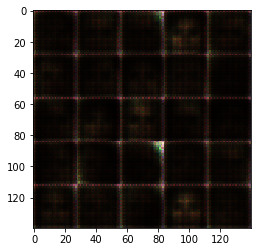

Epoch:  0 Batch:  110 Discriminator_Loss:  1.54503 Generator_Loss:  0.625709
Epoch:  0 Batch:  120 Discriminator_Loss:  1.33049 Generator_Loss:  1.75227
Epoch:  0 Batch:  130 Discriminator_Loss:  1.70778 Generator_Loss:  0.428949
Epoch:  0 Batch:  140 Discriminator_Loss:  1.80808 Generator_Loss:  0.536536
Epoch:  0 Batch:  150 Discriminator_Loss:  1.71978 Generator_Loss:  0.798172
Epoch:  0 Batch:  160 Discriminator_Loss:  1.54048 Generator_Loss:  0.599269
Epoch:  0 Batch:  170 Discriminator_Loss:  1.51526 Generator_Loss:  0.605671
Epoch:  0 Batch:  180 Discriminator_Loss:  1.48701 Generator_Loss:  1.39499
Epoch:  0 Batch:  190 Discriminator_Loss:  1.54396 Generator_Loss:  0.553299
Epoch:  0 Batch:  200 Discriminator_Loss:  1.835 Generator_Loss:  0.356296


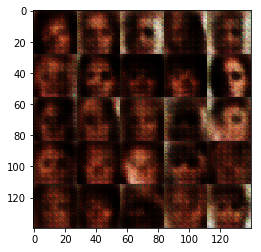

Epoch:  0 Batch:  210 Discriminator_Loss:  1.53827 Generator_Loss:  0.493267
Epoch:  0 Batch:  220 Discriminator_Loss:  1.40298 Generator_Loss:  0.627558
Epoch:  0 Batch:  230 Discriminator_Loss:  1.88714 Generator_Loss:  0.382199
Epoch:  0 Batch:  240 Discriminator_Loss:  1.22154 Generator_Loss:  1.1393
Epoch:  0 Batch:  250 Discriminator_Loss:  1.71032 Generator_Loss:  0.494029
Epoch:  0 Batch:  260 Discriminator_Loss:  1.71654 Generator_Loss:  0.645302
Epoch:  0 Batch:  270 Discriminator_Loss:  1.7561 Generator_Loss:  0.554717
Epoch:  0 Batch:  280 Discriminator_Loss:  1.64696 Generator_Loss:  0.586403
Epoch:  0 Batch:  290 Discriminator_Loss:  1.4041 Generator_Loss:  0.859813
Epoch:  0 Batch:  300 Discriminator_Loss:  1.61965 Generator_Loss:  0.626942


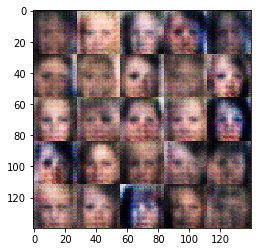

Epoch:  0 Batch:  310 Discriminator_Loss:  1.76723 Generator_Loss:  0.682343
Epoch:  0 Batch:  320 Discriminator_Loss:  1.54294 Generator_Loss:  0.718019
Epoch:  0 Batch:  330 Discriminator_Loss:  1.58861 Generator_Loss:  0.633144
Epoch:  0 Batch:  340 Discriminator_Loss:  1.56226 Generator_Loss:  0.674978
Epoch:  0 Batch:  350 Discriminator_Loss:  1.62696 Generator_Loss:  0.636218
Epoch:  0 Batch:  360 Discriminator_Loss:  1.67578 Generator_Loss:  0.600189
Epoch:  0 Batch:  370 Discriminator_Loss:  1.62259 Generator_Loss:  0.630469
Epoch:  0 Batch:  380 Discriminator_Loss:  1.47723 Generator_Loss:  0.75103
Epoch:  0 Batch:  390 Discriminator_Loss:  1.6033 Generator_Loss:  0.600857
Epoch:  0 Batch:  400 Discriminator_Loss:  1.65254 Generator_Loss:  0.661851


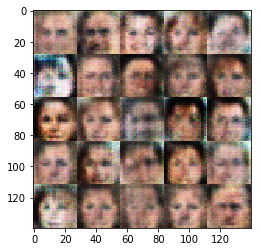

Epoch:  0 Batch:  410 Discriminator_Loss:  1.60556 Generator_Loss:  0.631886
Epoch:  0 Batch:  420 Discriminator_Loss:  1.51275 Generator_Loss:  0.732259
Epoch:  0 Batch:  430 Discriminator_Loss:  1.50189 Generator_Loss:  0.721392
Epoch:  0 Batch:  440 Discriminator_Loss:  1.54353 Generator_Loss:  0.668031
Epoch:  0 Batch:  450 Discriminator_Loss:  1.49081 Generator_Loss:  0.708145
Epoch:  0 Batch:  460 Discriminator_Loss:  1.54771 Generator_Loss:  0.67188
Epoch:  0 Batch:  470 Discriminator_Loss:  1.47963 Generator_Loss:  0.702499
Epoch:  0 Batch:  480 Discriminator_Loss:  1.51062 Generator_Loss:  0.731222
Epoch:  0 Batch:  490 Discriminator_Loss:  1.44101 Generator_Loss:  0.776102
Epoch:  0 Batch:  500 Discriminator_Loss:  1.46697 Generator_Loss:  0.731705


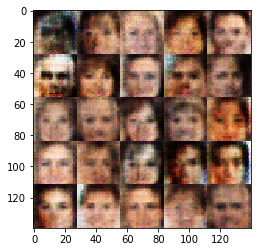

Epoch:  0 Batch:  510 Discriminator_Loss:  1.54113 Generator_Loss:  0.688153
Epoch:  0 Batch:  520 Discriminator_Loss:  1.5223 Generator_Loss:  0.70417
Epoch:  0 Batch:  530 Discriminator_Loss:  1.48807 Generator_Loss:  0.766702
Epoch:  0 Batch:  540 Discriminator_Loss:  1.55487 Generator_Loss:  0.638429
Epoch:  0 Batch:  550 Discriminator_Loss:  1.5327 Generator_Loss:  0.648823
Epoch:  0 Batch:  560 Discriminator_Loss:  1.51081 Generator_Loss:  0.704106
Epoch:  0 Batch:  570 Discriminator_Loss:  1.43456 Generator_Loss:  0.716232
Epoch:  0 Batch:  580 Discriminator_Loss:  1.42507 Generator_Loss:  0.745354
Epoch:  0 Batch:  590 Discriminator_Loss:  1.4944 Generator_Loss:  0.736398
Epoch:  0 Batch:  600 Discriminator_Loss:  1.56102 Generator_Loss:  0.669672


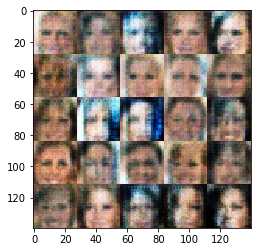

Epoch:  0 Batch:  610 Discriminator_Loss:  1.59245 Generator_Loss:  0.647039
Epoch:  0 Batch:  620 Discriminator_Loss:  1.45014 Generator_Loss:  0.72424
Epoch:  0 Batch:  630 Discriminator_Loss:  1.53867 Generator_Loss:  0.693071
Epoch:  0 Batch:  640 Discriminator_Loss:  1.45355 Generator_Loss:  0.739758
Epoch:  0 Batch:  650 Discriminator_Loss:  1.53523 Generator_Loss:  0.697981
Epoch:  0 Batch:  660 Discriminator_Loss:  1.47432 Generator_Loss:  0.753388
Epoch:  0 Batch:  670 Discriminator_Loss:  1.40275 Generator_Loss:  0.78099
Epoch:  0 Batch:  680 Discriminator_Loss:  1.47374 Generator_Loss:  0.739164
Epoch:  0 Batch:  690 Discriminator_Loss:  1.42682 Generator_Loss:  0.765914
Epoch:  0 Batch:  700 Discriminator_Loss:  1.52174 Generator_Loss:  0.69383


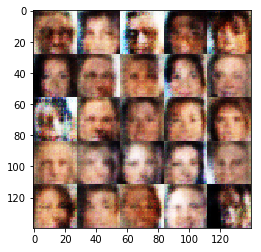

Epoch:  0 Batch:  710 Discriminator_Loss:  1.44199 Generator_Loss:  0.744889
Epoch:  0 Batch:  720 Discriminator_Loss:  1.46646 Generator_Loss:  0.693574
Epoch:  0 Batch:  730 Discriminator_Loss:  1.54329 Generator_Loss:  0.692091
Epoch:  0 Batch:  740 Discriminator_Loss:  1.46445 Generator_Loss:  0.713368
Epoch:  0 Batch:  750 Discriminator_Loss:  1.3574 Generator_Loss:  0.78313
Epoch:  0 Batch:  760 Discriminator_Loss:  1.48557 Generator_Loss:  0.753139
Epoch:  0 Batch:  770 Discriminator_Loss:  1.47743 Generator_Loss:  0.748674
Epoch:  0 Batch:  780 Discriminator_Loss:  1.44714 Generator_Loss:  0.740343
Epoch:  0 Batch:  790 Discriminator_Loss:  1.46796 Generator_Loss:  0.752532
Epoch:  0 Batch:  800 Discriminator_Loss:  1.36793 Generator_Loss:  0.782317


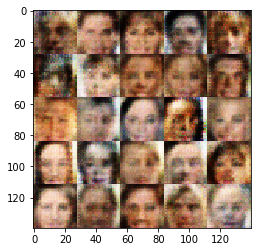

Epoch:  0 Batch:  810 Discriminator_Loss:  1.4349 Generator_Loss:  0.788628
Epoch:  0 Batch:  820 Discriminator_Loss:  1.40525 Generator_Loss:  0.740669
Epoch:  0 Batch:  830 Discriminator_Loss:  1.47648 Generator_Loss:  0.759256
Epoch:  0 Batch:  840 Discriminator_Loss:  1.46484 Generator_Loss:  0.773159
Epoch:  0 Batch:  850 Discriminator_Loss:  1.46036 Generator_Loss:  0.750147
Epoch:  0 Batch:  860 Discriminator_Loss:  1.49869 Generator_Loss:  0.714638
Epoch:  0 Batch:  870 Discriminator_Loss:  1.45201 Generator_Loss:  0.761659
Epoch:  0 Batch:  880 Discriminator_Loss:  1.3717 Generator_Loss:  0.804555
Epoch:  0 Batch:  890 Discriminator_Loss:  1.46518 Generator_Loss:  0.716694
Epoch:  0 Batch:  900 Discriminator_Loss:  1.50504 Generator_Loss:  0.732939


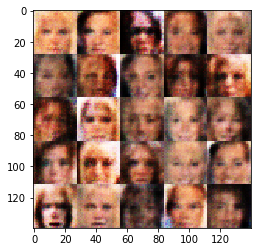

Epoch:  0 Batch:  910 Discriminator_Loss:  1.56129 Generator_Loss:  0.679474
Epoch:  0 Batch:  920 Discriminator_Loss:  1.42332 Generator_Loss:  0.75652
Epoch:  0 Batch:  930 Discriminator_Loss:  1.49057 Generator_Loss:  0.725652
Epoch:  0 Batch:  940 Discriminator_Loss:  1.38627 Generator_Loss:  0.828937
Epoch:  0 Batch:  950 Discriminator_Loss:  1.45181 Generator_Loss:  0.753803
Epoch:  0 Batch:  960 Discriminator_Loss:  1.45291 Generator_Loss:  0.729351
Epoch:  0 Batch:  970 Discriminator_Loss:  1.41964 Generator_Loss:  0.791595
Epoch:  0 Batch:  980 Discriminator_Loss:  1.46853 Generator_Loss:  0.736569
Epoch:  0 Batch:  990 Discriminator_Loss:  1.42337 Generator_Loss:  0.788492
Epoch:  0 Batch:  1000 Discriminator_Loss:  1.4101 Generator_Loss:  0.768628


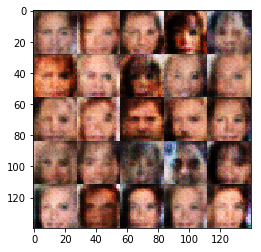

Epoch:  0 Batch:  1010 Discriminator_Loss:  1.43281 Generator_Loss:  0.769694
Epoch:  0 Batch:  1020 Discriminator_Loss:  1.45347 Generator_Loss:  0.751645
Epoch:  0 Batch:  1030 Discriminator_Loss:  1.46115 Generator_Loss:  0.720376
Epoch:  0 Batch:  1040 Discriminator_Loss:  1.45866 Generator_Loss:  0.743842
Epoch:  0 Batch:  1050 Discriminator_Loss:  1.53125 Generator_Loss:  0.692044
Epoch:  0 Batch:  1060 Discriminator_Loss:  1.41041 Generator_Loss:  0.752182
Epoch:  0 Batch:  1070 Discriminator_Loss:  1.45838 Generator_Loss:  0.733061
Epoch:  0 Batch:  1080 Discriminator_Loss:  1.47796 Generator_Loss:  0.752472
Epoch:  0 Batch:  1090 Discriminator_Loss:  1.43811 Generator_Loss:  0.732391
Epoch:  0 Batch:  1100 Discriminator_Loss:  1.53183 Generator_Loss:  0.67376


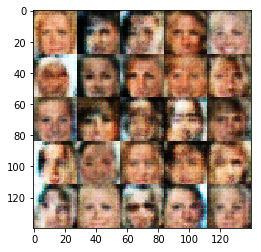

Epoch:  0 Batch:  1110 Discriminator_Loss:  1.45471 Generator_Loss:  0.762935
Epoch:  0 Batch:  1120 Discriminator_Loss:  1.44825 Generator_Loss:  0.746324
Epoch:  0 Batch:  1130 Discriminator_Loss:  1.46266 Generator_Loss:  0.772769
Epoch:  0 Batch:  1140 Discriminator_Loss:  1.46138 Generator_Loss:  0.748253
Epoch:  0 Batch:  1150 Discriminator_Loss:  1.45616 Generator_Loss:  0.742943
Epoch:  0 Batch:  1160 Discriminator_Loss:  1.48855 Generator_Loss:  0.741496
Epoch:  0 Batch:  1170 Discriminator_Loss:  1.42415 Generator_Loss:  0.765612
Epoch:  0 Batch:  1180 Discriminator_Loss:  1.44392 Generator_Loss:  0.686044
Epoch:  0 Batch:  1190 Discriminator_Loss:  1.40239 Generator_Loss:  0.829446
Epoch:  0 Batch:  1200 Discriminator_Loss:  1.41595 Generator_Loss:  0.768486


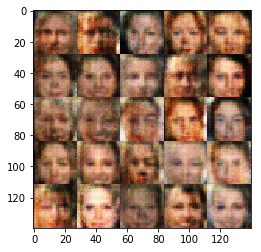

Epoch:  0 Batch:  1210 Discriminator_Loss:  1.45818 Generator_Loss:  0.756673
Epoch:  0 Batch:  1220 Discriminator_Loss:  1.42567 Generator_Loss:  0.809518
Epoch:  0 Batch:  1230 Discriminator_Loss:  1.40595 Generator_Loss:  0.795275
Epoch:  0 Batch:  1240 Discriminator_Loss:  1.42747 Generator_Loss:  0.747393
Epoch:  0 Batch:  1250 Discriminator_Loss:  1.46861 Generator_Loss:  0.69227
Epoch:  0 Batch:  1260 Discriminator_Loss:  1.40066 Generator_Loss:  0.785105
Epoch:  0 Batch:  1270 Discriminator_Loss:  1.48486 Generator_Loss:  0.693603
Epoch:  0 Batch:  1280 Discriminator_Loss:  1.41592 Generator_Loss:  0.756597
Epoch:  0 Batch:  1290 Discriminator_Loss:  1.41571 Generator_Loss:  0.780334
Epoch:  0 Batch:  1300 Discriminator_Loss:  1.503 Generator_Loss:  0.711796


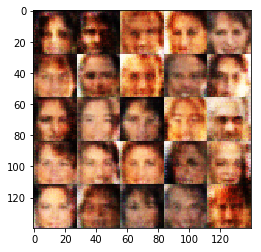

Epoch:  0 Batch:  1310 Discriminator_Loss:  1.45064 Generator_Loss:  0.721151
Epoch:  0 Batch:  1320 Discriminator_Loss:  1.482 Generator_Loss:  0.725756
Epoch:  0 Batch:  1330 Discriminator_Loss:  1.44289 Generator_Loss:  0.75032
Epoch:  0 Batch:  1340 Discriminator_Loss:  1.44862 Generator_Loss:  0.726943
Epoch:  0 Batch:  1350 Discriminator_Loss:  1.4695 Generator_Loss:  0.743129
Epoch:  0 Batch:  1360 Discriminator_Loss:  1.394 Generator_Loss:  0.821776
Epoch:  0 Batch:  1370 Discriminator_Loss:  1.37988 Generator_Loss:  0.803461
Epoch:  0 Batch:  1380 Discriminator_Loss:  1.49727 Generator_Loss:  0.733869
Epoch:  0 Batch:  1390 Discriminator_Loss:  1.40372 Generator_Loss:  0.770201
Epoch:  0 Batch:  1400 Discriminator_Loss:  1.38368 Generator_Loss:  0.76791


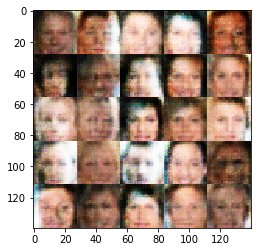

Epoch:  0 Batch:  1410 Discriminator_Loss:  1.47149 Generator_Loss:  0.752723
Epoch:  0 Batch:  1420 Discriminator_Loss:  1.4322 Generator_Loss:  0.767949
Epoch:  0 Batch:  1430 Discriminator_Loss:  1.44914 Generator_Loss:  0.771672
Epoch:  0 Batch:  1440 Discriminator_Loss:  1.46678 Generator_Loss:  0.717504
Epoch:  0 Batch:  1450 Discriminator_Loss:  1.45799 Generator_Loss:  0.780154
Epoch:  0 Batch:  1460 Discriminator_Loss:  1.42614 Generator_Loss:  0.703367
Epoch:  0 Batch:  1470 Discriminator_Loss:  1.45497 Generator_Loss:  0.76173
Epoch:  0 Batch:  1480 Discriminator_Loss:  1.50805 Generator_Loss:  0.749183
Epoch:  0 Batch:  1490 Discriminator_Loss:  1.37907 Generator_Loss:  0.827658
Epoch:  0 Batch:  1500 Discriminator_Loss:  1.38954 Generator_Loss:  0.786455


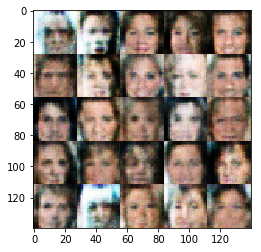

Epoch:  0 Batch:  1510 Discriminator_Loss:  1.44821 Generator_Loss:  0.729415
Epoch:  0 Batch:  1520 Discriminator_Loss:  1.39431 Generator_Loss:  0.752615
Epoch:  0 Batch:  1530 Discriminator_Loss:  1.46415 Generator_Loss:  0.764297
Epoch:  0 Batch:  1540 Discriminator_Loss:  1.4098 Generator_Loss:  0.780228
Epoch:  0 Batch:  1550 Discriminator_Loss:  1.39935 Generator_Loss:  0.787155
Epoch:  0 Batch:  1560 Discriminator_Loss:  1.45626 Generator_Loss:  0.719907
Epoch:  0 Batch:  1570 Discriminator_Loss:  1.44508 Generator_Loss:  0.757537
Epoch:  0 Batch:  1580 Discriminator_Loss:  1.43439 Generator_Loss:  0.750029
Epoch:  0 Batch:  1590 Discriminator_Loss:  1.41485 Generator_Loss:  0.725366
Epoch:  0 Batch:  1600 Discriminator_Loss:  1.48127 Generator_Loss:  0.734533


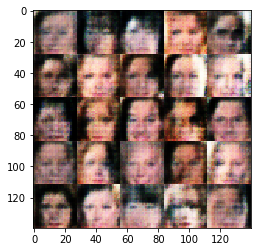

Epoch:  0 Batch:  1610 Discriminator_Loss:  1.38119 Generator_Loss:  0.800278
Epoch:  0 Batch:  1620 Discriminator_Loss:  1.52601 Generator_Loss:  0.70619
Epoch:  0 Batch:  1630 Discriminator_Loss:  1.43541 Generator_Loss:  0.740982
Epoch:  0 Batch:  1640 Discriminator_Loss:  1.45354 Generator_Loss:  0.743217
Epoch:  0 Batch:  1650 Discriminator_Loss:  1.42779 Generator_Loss:  0.792853
Epoch:  0 Batch:  1660 Discriminator_Loss:  1.46437 Generator_Loss:  0.760959
Epoch:  0 Batch:  1670 Discriminator_Loss:  1.34034 Generator_Loss:  0.800023
Epoch:  0 Batch:  1680 Discriminator_Loss:  1.46676 Generator_Loss:  0.703569
Epoch:  0 Batch:  1690 Discriminator_Loss:  1.44524 Generator_Loss:  0.790753
Epoch:  0 Batch:  1700 Discriminator_Loss:  1.4166 Generator_Loss:  0.739724


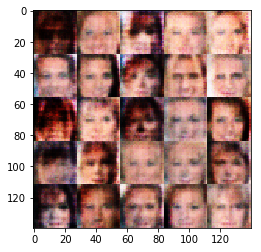

Epoch:  0 Batch:  1710 Discriminator_Loss:  1.42387 Generator_Loss:  0.746949
Epoch:  0 Batch:  1720 Discriminator_Loss:  1.44922 Generator_Loss:  0.780441
Epoch:  0 Batch:  1730 Discriminator_Loss:  1.42815 Generator_Loss:  0.721065
Epoch:  0 Batch:  1740 Discriminator_Loss:  1.36107 Generator_Loss:  0.795941
Epoch:  0 Batch:  1750 Discriminator_Loss:  1.38344 Generator_Loss:  0.817723
Epoch:  0 Batch:  1760 Discriminator_Loss:  1.40864 Generator_Loss:  0.761243
Epoch:  0 Batch:  1770 Discriminator_Loss:  1.39294 Generator_Loss:  0.769664
Epoch:  0 Batch:  1780 Discriminator_Loss:  1.43539 Generator_Loss:  0.783487
Epoch:  0 Batch:  1790 Discriminator_Loss:  1.36016 Generator_Loss:  0.803196
Epoch:  0 Batch:  1800 Discriminator_Loss:  1.50128 Generator_Loss:  0.734712


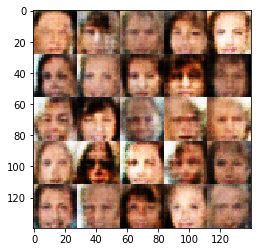

Epoch:  0 Batch:  1810 Discriminator_Loss:  1.44109 Generator_Loss:  0.749781
Epoch:  0 Batch:  1820 Discriminator_Loss:  1.39979 Generator_Loss:  0.771442
Epoch:  0 Batch:  1830 Discriminator_Loss:  1.43348 Generator_Loss:  0.752422
Epoch:  0 Batch:  1840 Discriminator_Loss:  1.35475 Generator_Loss:  0.792997
Epoch:  0 Batch:  1850 Discriminator_Loss:  1.42757 Generator_Loss:  0.733704
Epoch:  0 Batch:  1860 Discriminator_Loss:  1.43757 Generator_Loss:  0.738538
Epoch:  0 Batch:  1870 Discriminator_Loss:  1.40707 Generator_Loss:  0.806835
Epoch:  0 Batch:  1880 Discriminator_Loss:  1.41865 Generator_Loss:  0.755596
Epoch:  0 Batch:  1890 Discriminator_Loss:  1.42744 Generator_Loss:  0.747113
Epoch:  0 Batch:  1900 Discriminator_Loss:  1.47319 Generator_Loss:  0.747328


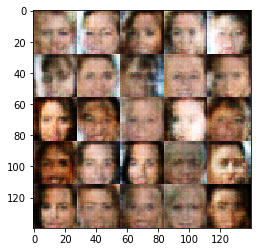

Epoch:  0 Batch:  1910 Discriminator_Loss:  1.39379 Generator_Loss:  0.772361
Epoch:  0 Batch:  1920 Discriminator_Loss:  1.43646 Generator_Loss:  0.798387
Epoch:  0 Batch:  1930 Discriminator_Loss:  1.37042 Generator_Loss:  0.797155
Epoch:  0 Batch:  1940 Discriminator_Loss:  1.46497 Generator_Loss:  0.743079
Epoch:  0 Batch:  1950 Discriminator_Loss:  1.37285 Generator_Loss:  0.815768
Epoch:  0 Batch:  1960 Discriminator_Loss:  1.46013 Generator_Loss:  0.730034
Epoch:  0 Batch:  1970 Discriminator_Loss:  1.39429 Generator_Loss:  0.7566
Epoch:  0 Batch:  1980 Discriminator_Loss:  1.4558 Generator_Loss:  0.716169
Epoch:  0 Batch:  1990 Discriminator_Loss:  1.43757 Generator_Loss:  0.715093
Epoch:  0 Batch:  2000 Discriminator_Loss:  1.51285 Generator_Loss:  0.700064


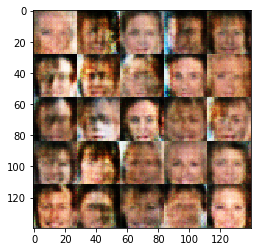

Epoch:  0 Batch:  2010 Discriminator_Loss:  1.48417 Generator_Loss:  0.711194
Epoch:  0 Batch:  2020 Discriminator_Loss:  1.41464 Generator_Loss:  0.772145
Epoch:  0 Batch:  2030 Discriminator_Loss:  1.42741 Generator_Loss:  0.761236
Epoch:  0 Batch:  2040 Discriminator_Loss:  1.40577 Generator_Loss:  0.765225
Epoch:  0 Batch:  2050 Discriminator_Loss:  1.45386 Generator_Loss:  0.811406
Epoch:  0 Batch:  2060 Discriminator_Loss:  1.4677 Generator_Loss:  0.760013
Epoch:  0 Batch:  2070 Discriminator_Loss:  1.44375 Generator_Loss:  0.739141
Epoch:  0 Batch:  2080 Discriminator_Loss:  1.39161 Generator_Loss:  0.771412
Epoch:  0 Batch:  2090 Discriminator_Loss:  1.43786 Generator_Loss:  0.738945
Epoch:  0 Batch:  2100 Discriminator_Loss:  1.38986 Generator_Loss:  0.787652


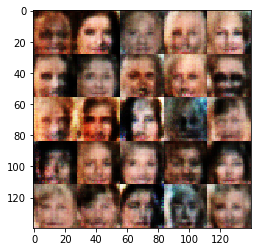

Epoch:  0 Batch:  2110 Discriminator_Loss:  1.42449 Generator_Loss:  0.764088
Epoch:  0 Batch:  2120 Discriminator_Loss:  1.42956 Generator_Loss:  0.732727
Epoch:  0 Batch:  2130 Discriminator_Loss:  1.38948 Generator_Loss:  0.807514
Epoch:  0 Batch:  2140 Discriminator_Loss:  1.35236 Generator_Loss:  0.805562
Epoch:  0 Batch:  2150 Discriminator_Loss:  1.42477 Generator_Loss:  0.780462
Epoch:  0 Batch:  2160 Discriminator_Loss:  1.43165 Generator_Loss:  0.794753
Epoch:  0 Batch:  2170 Discriminator_Loss:  1.41225 Generator_Loss:  0.771697
Epoch:  0 Batch:  2180 Discriminator_Loss:  1.43017 Generator_Loss:  0.716017
Epoch:  0 Batch:  2190 Discriminator_Loss:  1.38549 Generator_Loss:  0.778158
Epoch:  0 Batch:  2200 Discriminator_Loss:  1.42033 Generator_Loss:  0.780463


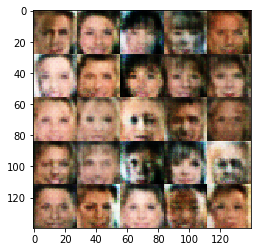

Epoch:  0 Batch:  2210 Discriminator_Loss:  1.4332 Generator_Loss:  0.749156
Epoch:  0 Batch:  2220 Discriminator_Loss:  1.45613 Generator_Loss:  0.715572
Epoch:  0 Batch:  2230 Discriminator_Loss:  1.4908 Generator_Loss:  0.704315
Epoch:  0 Batch:  2240 Discriminator_Loss:  1.37745 Generator_Loss:  0.799031
Epoch:  0 Batch:  2250 Discriminator_Loss:  1.46448 Generator_Loss:  0.709605
Epoch:  0 Batch:  2260 Discriminator_Loss:  1.38546 Generator_Loss:  0.753401
Epoch:  0 Batch:  2270 Discriminator_Loss:  1.36416 Generator_Loss:  0.776863
Epoch:  0 Batch:  2280 Discriminator_Loss:  1.45433 Generator_Loss:  0.715157
Epoch:  0 Batch:  2290 Discriminator_Loss:  1.47301 Generator_Loss:  0.771416
Epoch:  0 Batch:  2300 Discriminator_Loss:  1.43413 Generator_Loss:  0.749573


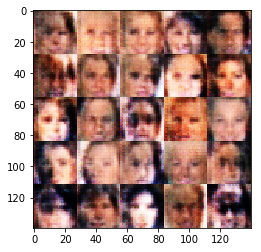

Epoch:  0 Batch:  2310 Discriminator_Loss:  1.43038 Generator_Loss:  0.799786
Epoch:  0 Batch:  2320 Discriminator_Loss:  1.4165 Generator_Loss:  0.742728
Epoch:  0 Batch:  2330 Discriminator_Loss:  1.39962 Generator_Loss:  0.807465
Epoch:  0 Batch:  2340 Discriminator_Loss:  1.38341 Generator_Loss:  0.798066
Epoch:  0 Batch:  2350 Discriminator_Loss:  1.43494 Generator_Loss:  0.703883
Epoch:  0 Batch:  2360 Discriminator_Loss:  1.42286 Generator_Loss:  0.749037
Epoch:  0 Batch:  2370 Discriminator_Loss:  1.40733 Generator_Loss:  0.825996
Epoch:  0 Batch:  2380 Discriminator_Loss:  1.41637 Generator_Loss:  0.77306
Epoch:  0 Batch:  2390 Discriminator_Loss:  1.37969 Generator_Loss:  0.800415
Epoch:  0 Batch:  2400 Discriminator_Loss:  1.39136 Generator_Loss:  0.803639


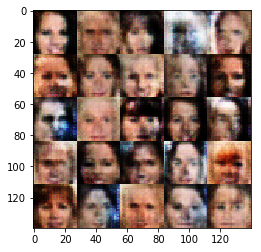

Epoch:  0 Batch:  2410 Discriminator_Loss:  1.41723 Generator_Loss:  0.782994
Epoch:  0 Batch:  2420 Discriminator_Loss:  1.39542 Generator_Loss:  0.783728
Epoch:  0 Batch:  2430 Discriminator_Loss:  1.35732 Generator_Loss:  0.861977
Epoch:  0 Batch:  2440 Discriminator_Loss:  1.41971 Generator_Loss:  0.794872
Epoch:  0 Batch:  2450 Discriminator_Loss:  1.50898 Generator_Loss:  0.759989
Epoch:  0 Batch:  2460 Discriminator_Loss:  1.38477 Generator_Loss:  0.821016
Epoch:  0 Batch:  2470 Discriminator_Loss:  1.45878 Generator_Loss:  0.715969
Epoch:  0 Batch:  2480 Discriminator_Loss:  1.41198 Generator_Loss:  0.783737
Epoch:  0 Batch:  2490 Discriminator_Loss:  1.38557 Generator_Loss:  0.781073
Epoch:  0 Batch:  2500 Discriminator_Loss:  1.47964 Generator_Loss:  0.744829


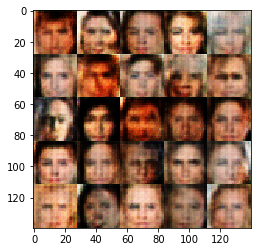

Epoch:  0 Batch:  2510 Discriminator_Loss:  1.35789 Generator_Loss:  0.811631
Epoch:  0 Batch:  2520 Discriminator_Loss:  1.45291 Generator_Loss:  0.712978
Epoch:  0 Batch:  2530 Discriminator_Loss:  1.45533 Generator_Loss:  0.763327
Epoch:  0 Batch:  2540 Discriminator_Loss:  1.49335 Generator_Loss:  0.625455
Epoch:  0 Batch:  2550 Discriminator_Loss:  1.50325 Generator_Loss:  0.779276
Epoch:  0 Batch:  2560 Discriminator_Loss:  1.48244 Generator_Loss:  0.733917
Epoch:  0 Batch:  2570 Discriminator_Loss:  1.40972 Generator_Loss:  0.740091
Epoch:  0 Batch:  2580 Discriminator_Loss:  1.44081 Generator_Loss:  0.805664
Epoch:  0 Batch:  2590 Discriminator_Loss:  1.40154 Generator_Loss:  0.756971
Epoch:  0 Batch:  2600 Discriminator_Loss:  1.41918 Generator_Loss:  0.811664


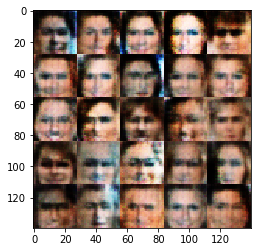

Epoch:  0 Batch:  2610 Discriminator_Loss:  1.3472 Generator_Loss:  0.784599
Epoch:  0 Batch:  2620 Discriminator_Loss:  1.41667 Generator_Loss:  0.719643
Epoch:  0 Batch:  2630 Discriminator_Loss:  1.38016 Generator_Loss:  0.800855
Epoch:  0 Batch:  2640 Discriminator_Loss:  1.35134 Generator_Loss:  0.772333
Epoch:  0 Batch:  2650 Discriminator_Loss:  1.41285 Generator_Loss:  0.756516
Epoch:  0 Batch:  2660 Discriminator_Loss:  1.44086 Generator_Loss:  0.792745
Epoch:  0 Batch:  2670 Discriminator_Loss:  1.3918 Generator_Loss:  0.712101
Epoch:  0 Batch:  2680 Discriminator_Loss:  1.38354 Generator_Loss:  0.826855
Epoch:  0 Batch:  2690 Discriminator_Loss:  1.44727 Generator_Loss:  0.828378
Epoch:  0 Batch:  2700 Discriminator_Loss:  1.40093 Generator_Loss:  0.751456


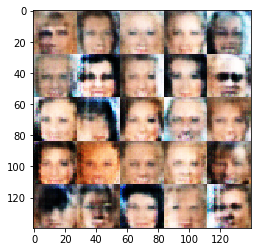

Epoch:  0 Batch:  2710 Discriminator_Loss:  1.41518 Generator_Loss:  0.827902
Epoch:  0 Batch:  2720 Discriminator_Loss:  1.47727 Generator_Loss:  0.743664
Epoch:  0 Batch:  2730 Discriminator_Loss:  1.49821 Generator_Loss:  0.659827
Epoch:  0 Batch:  2740 Discriminator_Loss:  1.34564 Generator_Loss:  0.839074
Epoch:  0 Batch:  2750 Discriminator_Loss:  1.35548 Generator_Loss:  0.825592
Epoch:  0 Batch:  2760 Discriminator_Loss:  1.36576 Generator_Loss:  0.775122
Epoch:  0 Batch:  2770 Discriminator_Loss:  1.45037 Generator_Loss:  0.708883
Epoch:  0 Batch:  2780 Discriminator_Loss:  1.43236 Generator_Loss:  0.799837
Epoch:  0 Batch:  2790 Discriminator_Loss:  1.5085 Generator_Loss:  0.684274
Epoch:  0 Batch:  2800 Discriminator_Loss:  1.41297 Generator_Loss:  0.737044


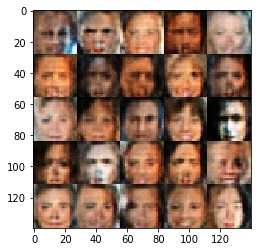

Epoch:  0 Batch:  2810 Discriminator_Loss:  1.46417 Generator_Loss:  0.730924
Epoch:  0 Batch:  2820 Discriminator_Loss:  1.39432 Generator_Loss:  0.796859
Epoch:  0 Batch:  2830 Discriminator_Loss:  1.44618 Generator_Loss:  0.737656
Epoch:  0 Batch:  2840 Discriminator_Loss:  1.44973 Generator_Loss:  0.790132
Epoch:  0 Batch:  2850 Discriminator_Loss:  1.41113 Generator_Loss:  0.726442
Epoch:  0 Batch:  2860 Discriminator_Loss:  1.41033 Generator_Loss:  0.752099
Epoch:  0 Batch:  2870 Discriminator_Loss:  1.39216 Generator_Loss:  0.767654
Epoch:  0 Batch:  2880 Discriminator_Loss:  1.35799 Generator_Loss:  0.809337
Epoch:  0 Batch:  2890 Discriminator_Loss:  1.42153 Generator_Loss:  0.742798
Epoch:  0 Batch:  2900 Discriminator_Loss:  1.43854 Generator_Loss:  0.800548


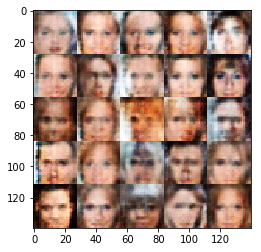

Epoch:  0 Batch:  2910 Discriminator_Loss:  1.44564 Generator_Loss:  0.767286
Epoch:  0 Batch:  2920 Discriminator_Loss:  1.3843 Generator_Loss:  0.763229
Epoch:  0 Batch:  2930 Discriminator_Loss:  1.34733 Generator_Loss:  0.849219
Epoch:  0 Batch:  2940 Discriminator_Loss:  1.42584 Generator_Loss:  0.735246
Epoch:  0 Batch:  2950 Discriminator_Loss:  1.45695 Generator_Loss:  0.725635
Epoch:  0 Batch:  2960 Discriminator_Loss:  1.4364 Generator_Loss:  0.738442
Epoch:  0 Batch:  2970 Discriminator_Loss:  1.41512 Generator_Loss:  0.749301
Epoch:  0 Batch:  2980 Discriminator_Loss:  1.40676 Generator_Loss:  0.779891
Epoch:  0 Batch:  2990 Discriminator_Loss:  1.44861 Generator_Loss:  0.718365
Epoch:  0 Batch:  3000 Discriminator_Loss:  1.41529 Generator_Loss:  0.763833


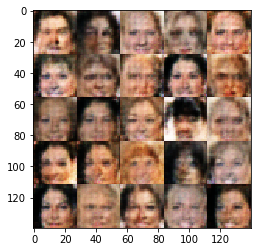

Epoch:  0 Batch:  3010 Discriminator_Loss:  1.43829 Generator_Loss:  0.731782
Epoch:  0 Batch:  3020 Discriminator_Loss:  1.44612 Generator_Loss:  0.761374
Epoch:  0 Batch:  3030 Discriminator_Loss:  1.42881 Generator_Loss:  0.714557
Epoch:  0 Batch:  3040 Discriminator_Loss:  1.44895 Generator_Loss:  0.785235
Epoch:  0 Batch:  3050 Discriminator_Loss:  1.42463 Generator_Loss:  0.77031
Epoch:  0 Batch:  3060 Discriminator_Loss:  1.4241 Generator_Loss:  0.735116
Epoch:  0 Batch:  3070 Discriminator_Loss:  1.46137 Generator_Loss:  0.736458
Epoch:  0 Batch:  3080 Discriminator_Loss:  1.41797 Generator_Loss:  0.75472
Epoch:  0 Batch:  3090 Discriminator_Loss:  1.39859 Generator_Loss:  0.814459
Epoch:  0 Batch:  3100 Discriminator_Loss:  1.36973 Generator_Loss:  0.810512


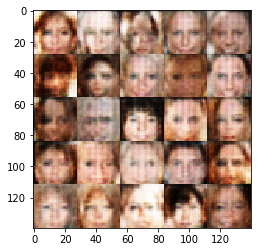

Epoch:  0 Batch:  3110 Discriminator_Loss:  1.40171 Generator_Loss:  0.753504
Epoch:  0 Batch:  3120 Discriminator_Loss:  1.45978 Generator_Loss:  0.737342
Epoch:  0 Batch:  3130 Discriminator_Loss:  1.39453 Generator_Loss:  0.810358
Epoch:  0 Batch:  3140 Discriminator_Loss:  1.40158 Generator_Loss:  0.803275
Epoch:  0 Batch:  3150 Discriminator_Loss:  1.43141 Generator_Loss:  0.770148
Epoch:  0 Batch:  3160 Discriminator_Loss:  1.43387 Generator_Loss:  0.79241


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.